# Signals, Sampling & Filtering
---
<div><center><img src="../images/fft-image.png" width=800></center></div>

(Image courtesy of Prof. Romeo Chua - take his **KIN 419** course!)

---
# Overview and Learning Objectives

- Signals in nature (such as sound waves, magnetic fields, hand position, electromyograms (EMG), electroencephalograms (EEG), extra-cellular potentials, etc) vary continuously
- In research, we typically measure these signals by **sampling** them repeatedly over time, at some **sampling frequency**
- The resulting collection of measurements is a **discretized** (non-continuous/separated) representation of the original continuous signal.
- **Fourier analysis** is a way of decomposing complex signals into component sines and cosines (i.e., sinusoids)
- **Fast Fourier transform (FFT)** is a very efficient computational algorithm for computing the magnitude and phase (angle) of these component sines and cosines 
- Filtering leverages the power of FFTs and provides a means of taking out undesired signal frequencies (typically, noise)
- Knowing how to implement a discrete FFT and filter a signal in Python are extremely useful skills, especially for experimental work with EMG, EEG, kinematics, kinetics, etc. 
- **Caveat:** signal processing is a very deep subject that can easily occupy a semester's worth of materials (in addition to Dr. Chua's KIN 419, see Dr. Blouin's KIN 501 Computational Methods for Data Acquisition and Signal Processing in Kinesiology)
- Here, the focus is on developing our conceptual understanding of the topic and to provide some Python-ic implementations of common signal processing algorithms

---
# Time domain representation of signals

- Before we get into **sampling theory** however we should first cover some basic terminology and talk about how signals can be represented both in the **time domain** and in the **frequency domain**.
- **Terminology:**
    - **Frequency** - number of cycles per unit time (usually seconds)
    - **Period** - how long it takes to go through a full cycle (i.e., 2$\pi$ radians)
    - **Phase** - angular position 
- Probably most common way of thinking about signals, namely how the magnitude of a signal varies over time. 
- For example a signal $s$ containing a sinusoid with a period $T$ of 0.5 seconds (a frequency of 2 Hz, since $\text{frequency}=\frac{1}{T}$) and a peak-to-peak magnitude $b$ of 2 volts is represented in the time domain $t$ as:

\begin{align}
s(t) &= \left(\frac{b}{2}\right) \mathrm{sin}\left(wt\right) \\
\text{where } w &= \frac{2 \pi}{T} 
\end{align}

- We can visualize the signal by plotting its magnitude as a function of time:

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

%matplotlib inline
%config InlineBackend.figure_format = "retina"

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


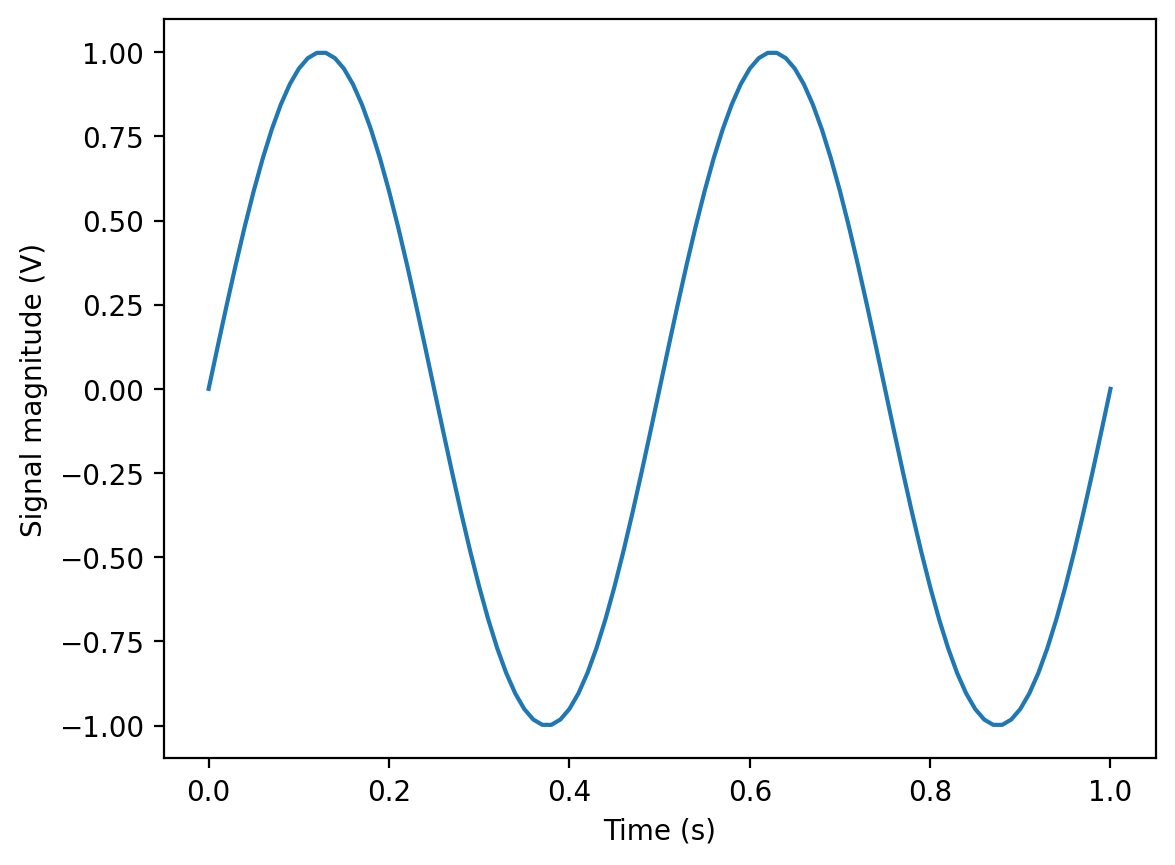

In [2]:
# Define our sine wave
T = 0.5  # period (1 / frequency)
b = 2  # peak-to-peak amplitude
w = 2 * np.pi / T
t = np.linspace(0, 1, 101)
s = b / 2 * np.sin(w * t)

# Plot our sine wave
fig, ax = plt.subplots()
ax.plot(t, s)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal magnitude (V)")
plt.show()

---
# Frequency domain representation of signals

- We can also represent signals in the frequency domain. 
- This requires some understanding of the [Fourier series](http://en.wikipedia.org/wiki/Fourier_series). 
- The idea of the Fourier series is that all periodic signals can be represented by (decomposed into) the sum of a set of pure sines and cosines that differ in frequency (# of cycles / unit time [usually seconds]) and period (time it takes to complete 1 cycle). 

$$ s(t) = \frac{a_{0}}{2} + \sum_{n=1}^{\infty} \left[a_{n}\mathrm{cos}(nwt) + b_{n}\mathrm{sin}(nwt)\right] $$

- The coefficients $a_{n}$ and $b_{n}$ define the weighting of the different sines and cosines at different frequencies. 
- In other words these coefficients represent the strength of the different frequency components in the signal.
- We can also represent the Fourier series in an even more compact form:

$$ s(t) = \frac{a_{0}}{2} +  \sum_{n=1}^{\infty} \left[r_{n}\mathrm{cos}(nwt-\phi_{n})\right] $$

- Using this formulation we now have **magnitude** coefficients $r_{n}$ and **phase** coefficients $\phi_{n}$. That is, we are representing the original signal $s(t)$ using a sum of sinusoids (sine-like wave forms; also remember, cosine is a $\pi/2$ phase-shifted version of sine) of different frequencies and phases.
- **Again, the big idea is that complex signals can be decomposed into differentially weighted sinusoids of different frequencies**



## Fast Fourier transform (FFT)

- Given a signal there is a very efficient computational algorithm called the [Fast Fourier transform](http://en.wikipedia.org/wiki/Fast_Fourier_transform) (FFT) for computing the magnitude and phase coefficients. 
- We will not go into the details of this algorithm here, most high level programming languages have a library that includes the FFT algorithm
- Before going into computing the FFT, we must go over the basics of sampling (a signal, not a population) 


## Sampling

- In theory we can derive a mathematical description of the Fourier decomposition of a continuous signal, as we have done above, in terms of an infinite number of sinusoids. 
- In practice however, signals are not continuous, but are **sampled** (i.e., measured or recorded) at some discrete **sampling rate**.
- For example, when we use Optotrak to record the position of the fingertip during pointing experiments, we choose a sampling rate of 200 Hz. 
- This means 200 times per second (Hz) the measurement instrument samples and records the position of the fingertip. Thus, the interval between any two samples is 5 ms. 
- Sampling rate used has a specific effect on the number of frequencies used in a discrete Fourier representation of the recorded signals.

## Sampling 

- The [Shannon-Nyquist sampling theorem](http://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) states that *a signal must be sampled at a rate which is at least twice that of its highest frequency component*. 
- The [Nyquist frequency](http://en.wikipedia.org/wiki/Nyquist_frequency) refers to the fastest frequency component that can be reliably measured (i.e., half the sampling rate)
- If a signal contains power at frequencies higher than half the sampling rate, these high frequency components will appear in the sampled data at lower frequencies and will distort the recording. 
- This is known as the problem of [aliasing](http://en.wikipedia.org/wiki/Aliasing).
- Let's see an example of aliasing: 
    - Solid blue line = 2 Hz signal
    - Magenta dashed line = 4 Hz signal
    - Green dashed line = 8 Hz signal
    - Vertical red lines = samples occurring every 2 Hz 
<div><center><img src="../images/signal-aliasing.jpg" width=800></center></div>


- Notice that at the sample points (vertical red lines), the 2 Hz, 4 Hz and 8 Hz signals overlap with identical values&mdash;very bad!
- This means that on the basis of our 2 Hz samples, we cannot distinguish between frequencies of 2, 4 and 8 Hz. 
- What's more, what this means is that if the signal we are actually sampling at 2 Hz has significant signal power at frequencies above the Nyquist (1 Hz) then the power at these higher frequencies will influence our estimates of the magnitude coefficients corresponding to frequencies below the Nyquist… in other words the high-frequency power will be aliased into the lower frequency estimates.


## The take home message

- Before choosing your sampling rate, you should have some knowledge about the highest frequency that you (a) are interested in identifying; and (b) you think is a real component in the signal (as opposed to random noise). 
- In cases where you have no a priori knowledge about the expected frequency content, one strategy is to remove high frequency components _before sampling_. This can be accomplished using low-pass filtering — sometimes called anti-aliasing filters. 
- Once the signal has been sampled, it's too late to perform anti-aliasing.

---
## Power spectra

- How to interpret magnitude and phase coefficients 
- For a given signal, the collection of magnitude coefficients gives a description of the signal in terms of the strength of the various underlying frequency components. 
- For our immediate purposes the magnitude coefficients will be most important and we will ignore phase coefficients.
- Here is an example of a power spectrum for a pure 10 Hz signal, sampled at 100 Hz.
<div><center><img src="../images/signal_spectrum10.jpg" width=800></center></div>

- The magnitude values are zero for every frequency except 10 Hz. We haven't plotted the phase coefficients. 
- The set of magnitude and phase coefficients derived from a Fourier analysis is a complete description of the underlying signal, with one caveat — only frequencies up to the Nyquist are represented. 
- So the idea here is that one can go between the original time-domain representation of the signal and this frequency domain representation of the signal without losing information. 


## FFT code example

Here are the steps involved:
- We construct a one second signal sampled at 1000 Hz that is composed of 6 Hz, 10 Hz and 13 Hz components (of course, in real data analysis, we would record the signal, not create one ourselves) 
- Note that another way of writing the equation for a sine wave is: 
$$s(t) = A \text{sin} (2 \pi f t)$$ where $A$ is the amplitude ($b/2$ in previous eqn) and $f$ is the frequency ($1/T$ in previous eqn).
- Then use the `scipy.fft.rfft()` function from the `SciPy` package to compute the Fast Fourier transform
- Extract the magnitude information
- Set our frequency range (up to the Nyquist) 
- Plot the **spectrum**:

In [3]:
# Create our signal
t = np.linspace(0, 1, 1000) # 1 second sampled at 1000 Hz
# Create 6, 10, and 13 Hz signals
y = np.sin(2 * np.pi * 6 * t) + np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 13 * t)

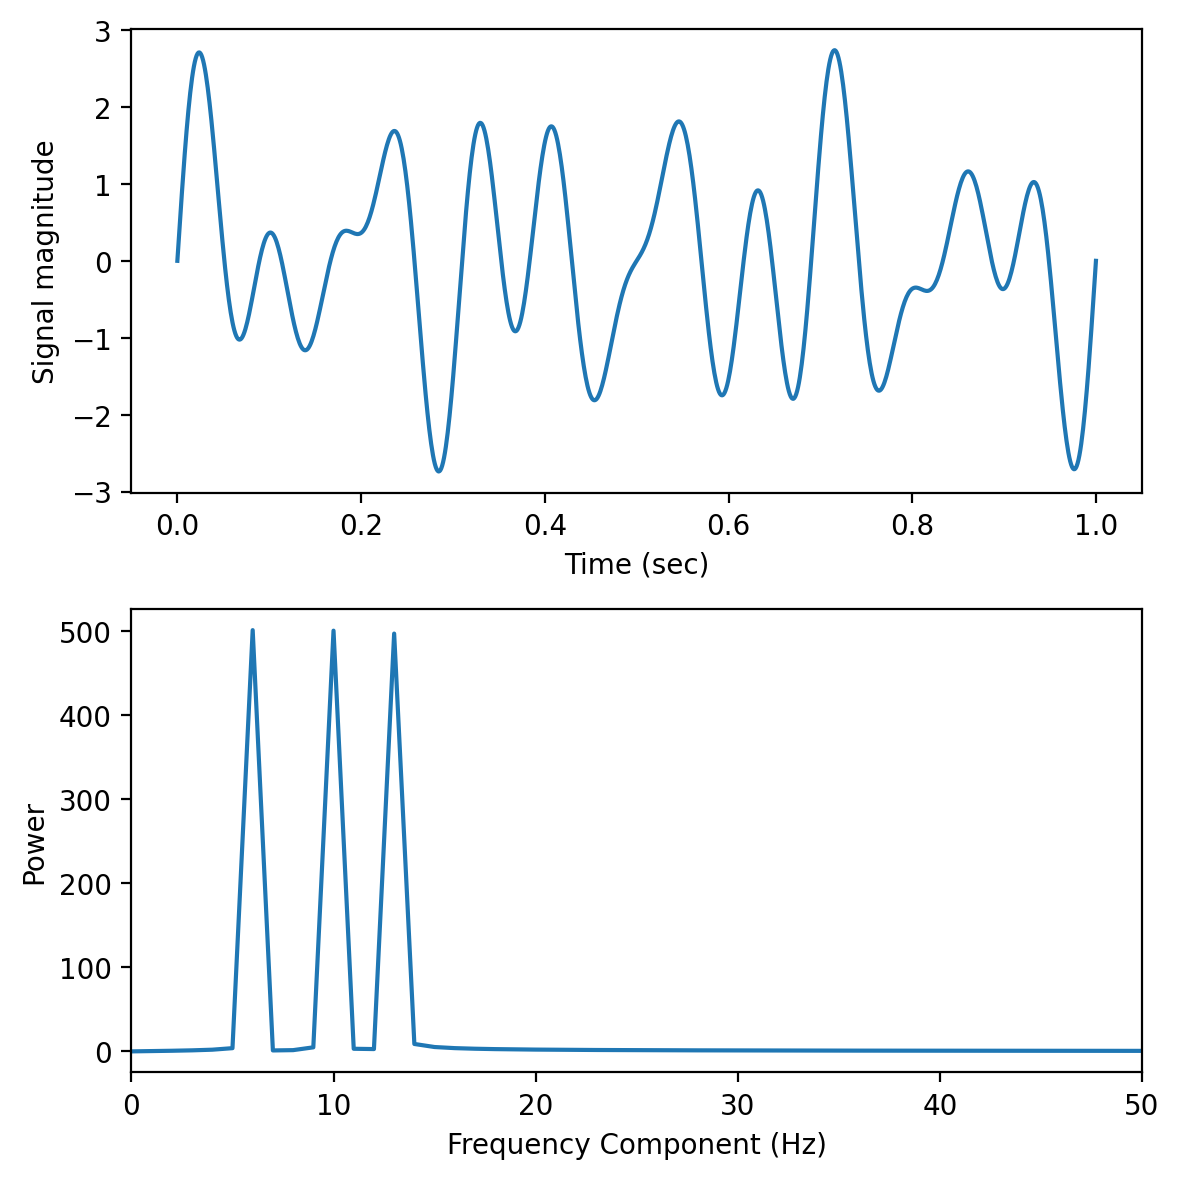

In [4]:
# Set-up our subplots
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(t, y)
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('Signal magnitude')

# Perform the FFT
out = sp.fft.rfft(y) # compute the FFT (rfft is fft on real-valued data and is preferred for speed)
mag = np.abs(out)  # extract the magnitude information
freqs = sp.fft.rfftfreq(len(y), d=1/1000) # compute the frequency range; d is sample spacing

# Plot the filtered signal
ax[1].plot(freqs, mag) # plot the magnitude spectrum up to the Nyquist
ax[1].set_xlim([0, 50]) # Zoom in on the first 50 Hz for visualization purposes 
ax[1].set_xlabel('Frequency Component (Hz)')
ax[1].set_ylabel('Power')

plt.tight_layout()

- Power spectrum has revealed peaks at 6, 10 and 13 Hz - which we know is correct, since we designed our signal from scratch!
- Typically however signals in the real world that we record are not pure sinusoids, but contain random noise. 
- Noise can originate from the actual underlying process that we are interested in measuring, and it can also originate from the instruments we use to measure the signal. 
- We deal with this issue by **filtering**



---
## Filtering

- Basic idea behind filtering is that we can perform operations within frequency space to manipulate the strength of different frequency components in our signal
- Very useful for eliminating noise sources with known frequency content
- Here is a short summary of different kinds of filters, and some terminology.
    - **low-pass filters** pass low frequencies without change, but attenuate (i.e. reduce) frequencies above the **cutoff frequency**
    - **high-pass filters** pass high frequencies and attenuate low frequencies, below the cutoff frequency
    - **band-pass filters** pass frequencies within a **pass band** frequency range and attenuate all others
    - **band-stop filters** (sometimes called **band-reject filters** or **notch filters**) attenuate frequencies within the **stop band** and pass all others


## Python code for filtering

In [5]:
def lowpass(y, samprate, cutoff, order=2):
    w = cutoff / (samprate / 2) # Normalize the cutoff frequency
    b, a = sp.signal.butter(N=order, Wn=w, btype='lowpass') # get the filter coefficients
    yf = sp.signal.filtfilt(b, a, y) # perform the filtering
    return yf

def highpass(y, samprate, cutoff, order=2):
    w = cutoff / (samprate / 2) # Normalize the cutoff frequency
    b, a = sp.signal.butter(N=order, Wn=w, btype='highpass') # get the filter coefficients
    yf = sp.signal.filtfilt(b, a, y) # perform the filtering
    return yf

def bandpass(y, samprate, cutoffs, order=2):
    cutoffs = np.array(cutoffs)
    w = cutoffs / (samprate / 2) # Normalize the cutoff frequencies
    b, a = sp.signal.butter(N=order, Wn=w, btype='bandpass') # get the filter coefficients
    yf = sp.signal.filtfilt(b, a, y) # perform the filtering
    return yf

def bandstop(y, samprate, cutoffs, order=2):
    cutoffs = np.array(cutoffs)
    w = cutoffs / (samprate / 2) # Normalize the cutoff frequencies
    b, a = sp.signal.butter(N=order, Wn=w, btype='bandstop') # get the filter coefficients
    yf = sp.signal.filtfilt(b, a, y) # perform the filtering
    return yf

## Demo of filtering broadband noise

Below, we will go through each of the different types of filters as applied to pure noise:

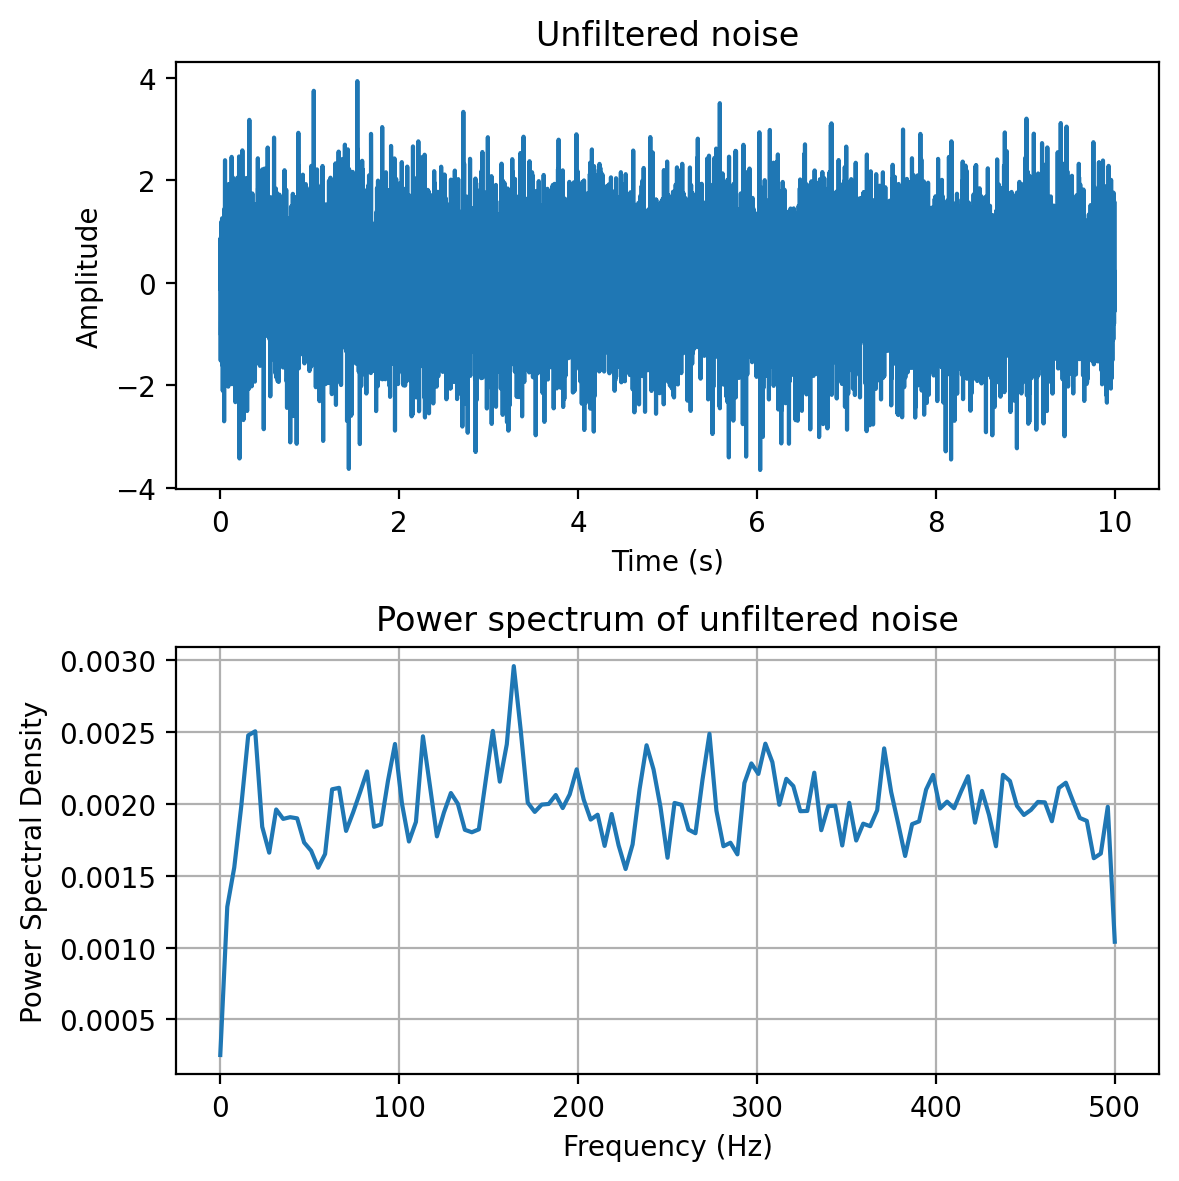

In [6]:
# Create our noise signal (made up of Gaussian noise centered around zero)
t = np.arange(0, 10, 1/1000)
y = np.random.randn(len(t))

# Perform power spectral density (another algorithm based on FFT)
freqs, psd = sp.signal.welch(y, fs=1000)

# Plot
fig,ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(t,y)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Unfiltered noise')
ax[1].plot(freqs,psd)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power Spectral Density')
ax[1].set_title('Power spectrum of unfiltered noise')
ax[1].grid()
plt.tight_layout()

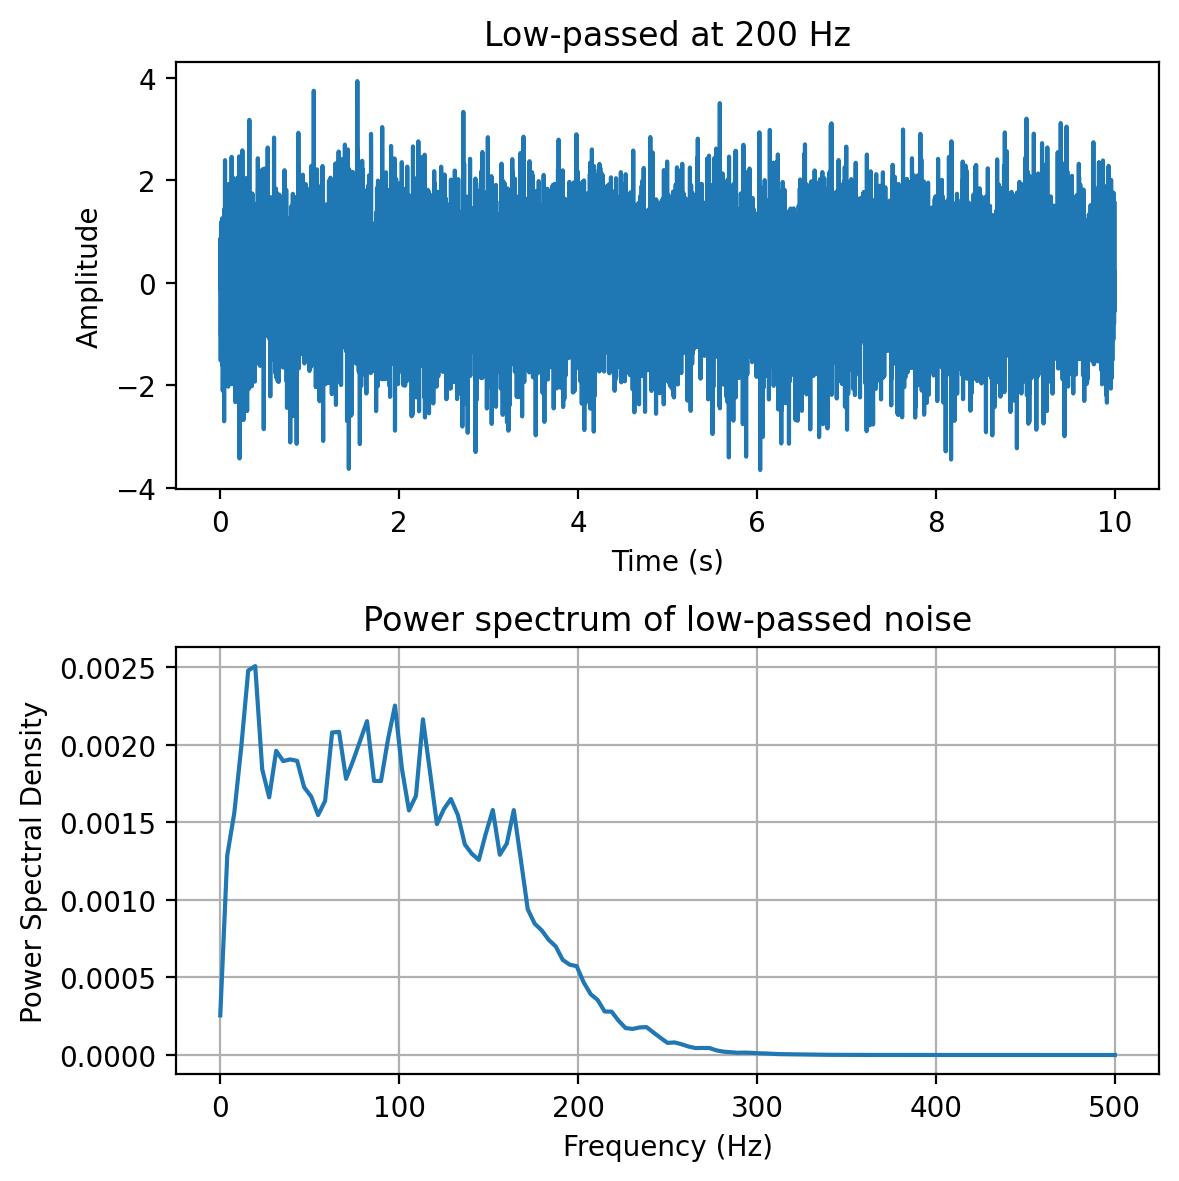

In [7]:
# Low pass filtering
yf = lowpass(y, 1000, 200) # low-pass filter at 200 Hz
freqs, psd = sp.signal.welch(yf,fs=1000)

# Plot the figure
fig,ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(t,y)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Low-passed at 200 Hz')
ax[1].plot(freqs,psd)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power Spectral Density')
ax[1].set_title('Power spectrum of low-passed noise')
ax[1].grid()
plt.tight_layout()

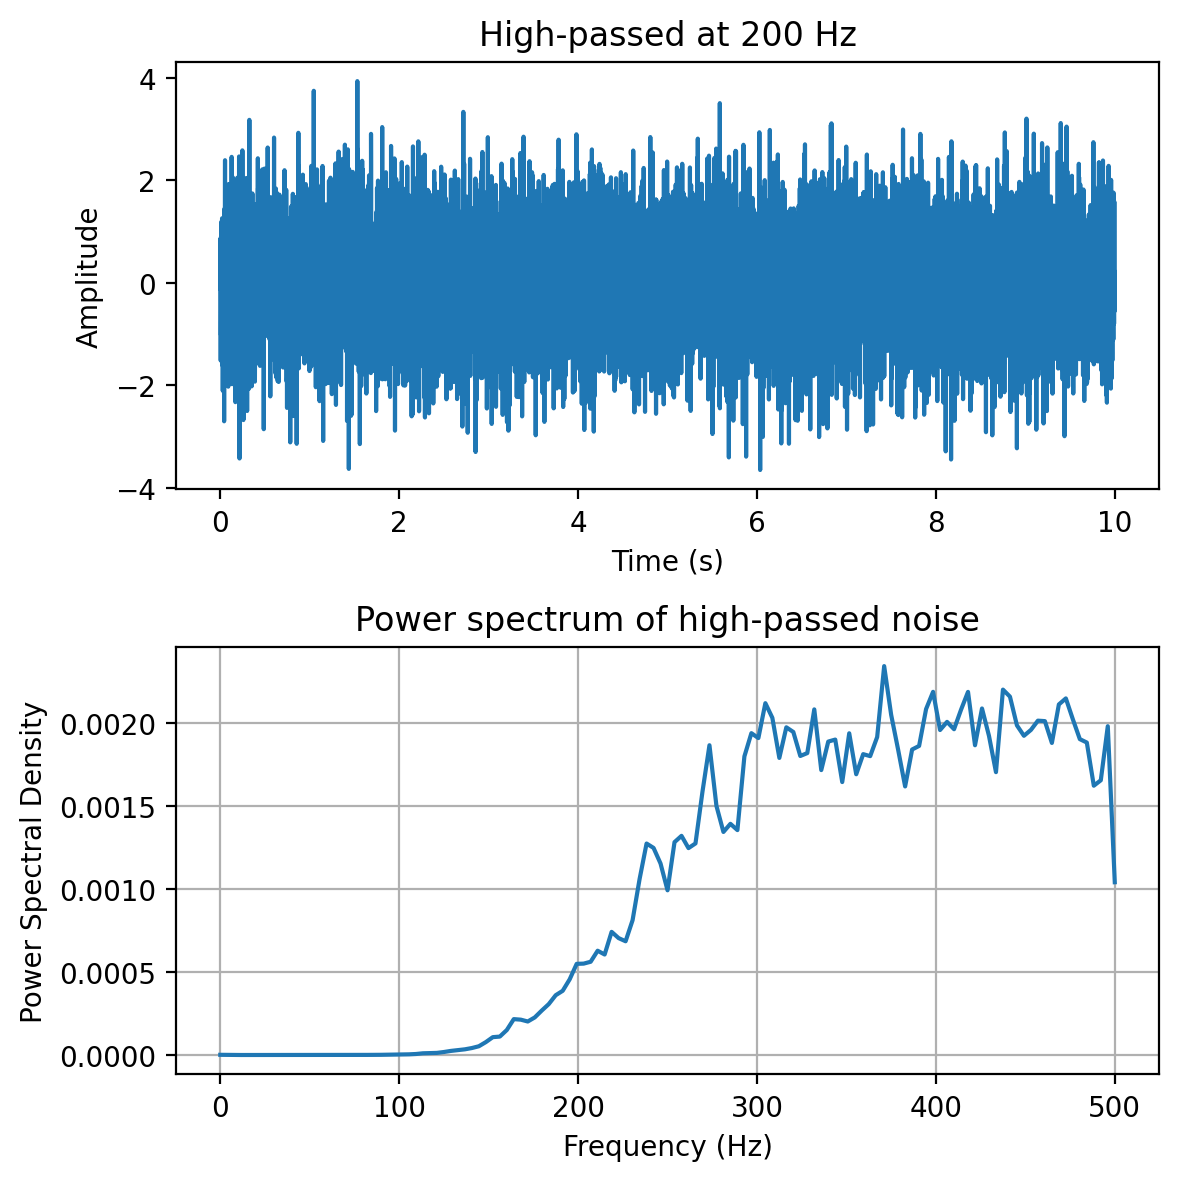

In [8]:
# High-pass filter
yf = highpass(y, 1000, 200) # high-pass filter at 200 Hz
freqs, psd = sp.signal.welch(yf,fs=1000)

# Plot
fig,ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(t,y)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('High-passed at 200 Hz')
ax[1].plot(freqs,psd)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power Spectral Density')
ax[1].set_title('Power spectrum of high-passed noise')
ax[1].grid()
plt.tight_layout()

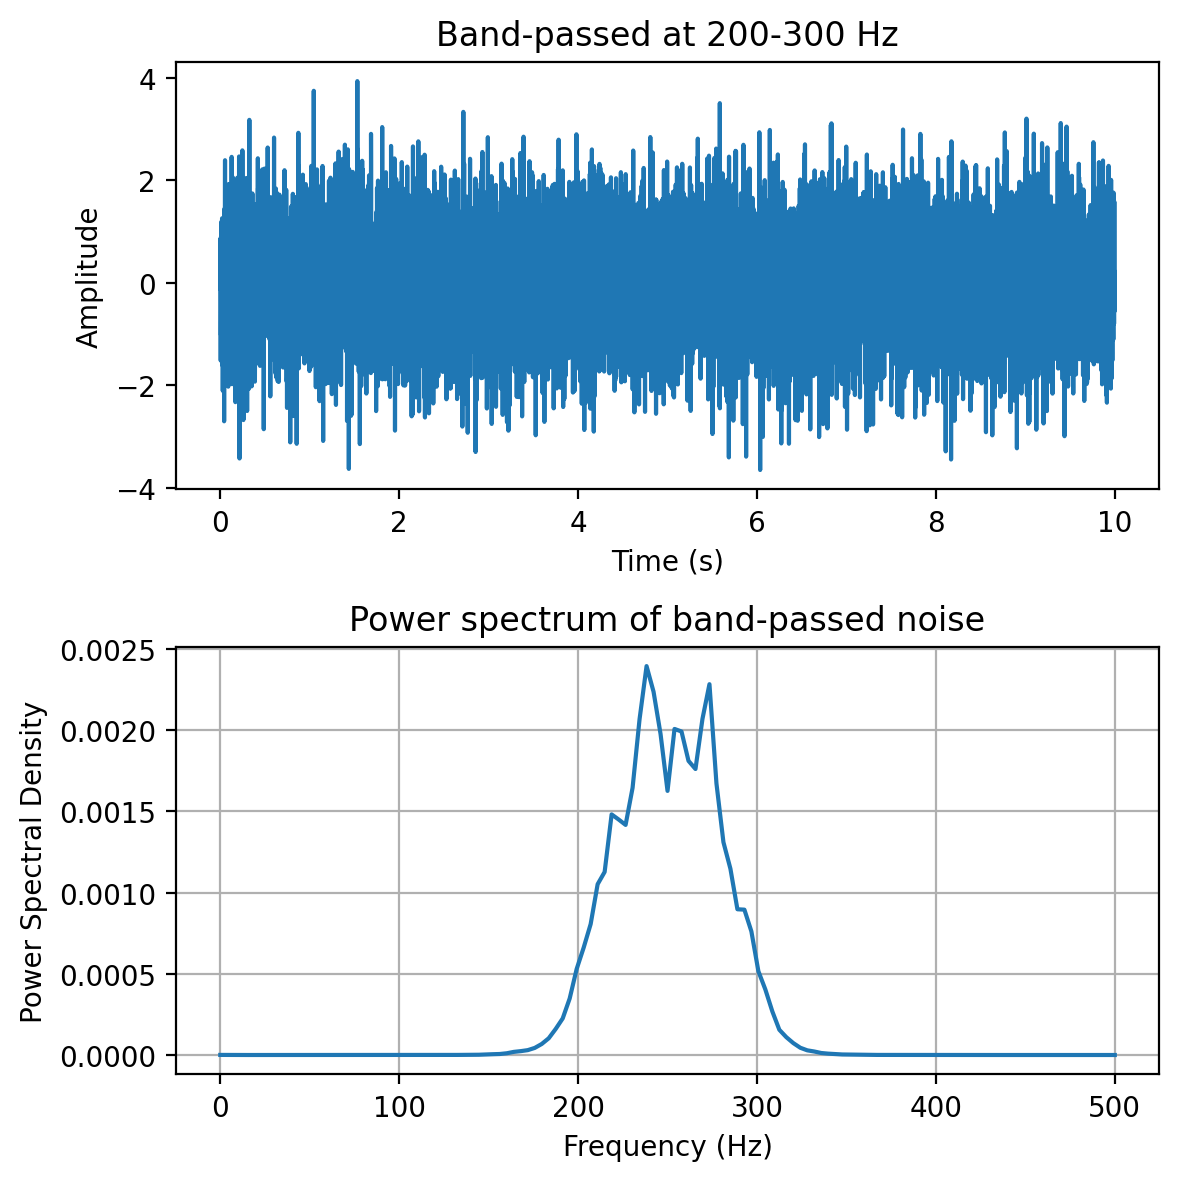

In [9]:
# Bandpass filter at 200-300 Hz
yf = bandpass(y, 1000, [200,300]) # band-pass filter at 200-300 Hz
freqs,psd = sp.signal.welch(yf, fs=1000)

# Plot
fig,ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(t, y)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Band-passed at 200-300 Hz')
ax[1].plot(freqs,psd)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power Spectral Density')
ax[1].set_title('Power spectrum of band-passed noise')
ax[1].grid()
plt.tight_layout()

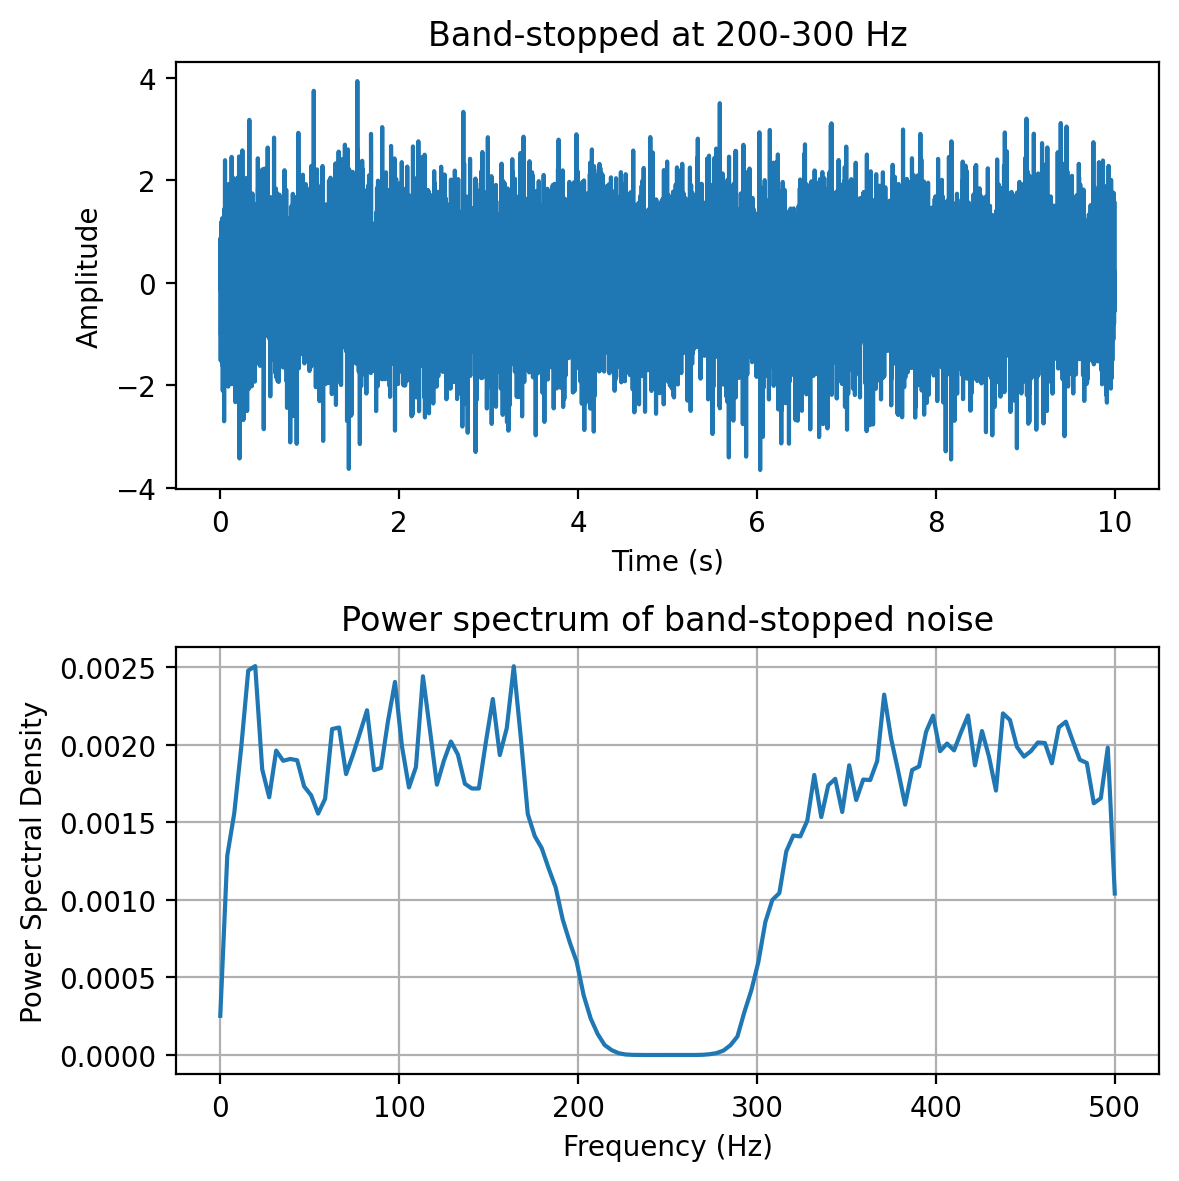

In [10]:
# Band stop filter at 200-300 Hz
yf = bandstop(y, 1000, [200,300]) # band-stop filter at 200-300 Hz
freqs, psd = sp.signal.welch(yf, fs=1000)

# Plot
fig,ax = plt.subplots(2, 1, figsize=(6,6))
ax[0].plot(t,y)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Band-stopped at 200-300 Hz')
ax[1].plot(freqs,psd)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power Spectral Density')
ax[1].set_title('Power spectrum of band-stopped noise')
ax[1].grid() 
plt.tight_layout()

- The figures above clearly demonstrate the results of different types of filters
- Notice that filtering does not perfectly eliminate unwanted frequencies (e.g., there is still some power above 200 Hz in our low-pass filtered data)
- **Roll-off** refers to the rate at which a filter attenuates the input (see [textbook chapter](https://hyosubkim.github.io/datasci-for-kin/8-signal_processing/signals-sampling-filtering.html#filtering) section on "Characterizing filter performance" for more details
- Different filter designs (e.g., Butterworth, Tschebyschev, etc.) may have sharper roll-offs than others but at the cost of something else (again, read chapter for more details)
- For now, understand the basic ideas behind these filter types and just realize that there are trade-offs
- Now we will start to think about more real-world applications

---
## Break: 15 minutes to complete course survey

- *Please* provide your feedback on the course&mdash;helps me know what is working well (and not as well); will aid future iterations of the course
- All responses are confidential
- Much appreciated!
- https://seoi.ubc.ca/surveys


---
## Application: high-frequency noise and taking derivatives (filtering kinematic data)

- Nearly all signals that you measure with your instrument will contain a combination of true signal and "noise" (random variations in the signal). 
- One salient reason to low-pass filter a signal, and remove high-frequency noise, is for cases in which we are interested in taking the temporal derivative of a signal. 
- For example, let's say we have recorded the position of the fingertip as a subject reaches from a start position on a tabletop, to a target located in front of them on a computer screen. Using a device like Optotrak we can record the (x, y, z) coordinates of the fingertip at a sampling rate of 200 Hz. Below is an example using simulated data of such a recording
- In the cell below, we create the simulated data:

In [11]:
# Simulate "position" signal with some noise 
t = np.linspace(0, 600, 601)
mu = 250
sigma = 25
x_dot = 2 * np.exp((t - mu)**2 / (-2 * sigma**2))
pos = np.cumsum(x_dot) + np.random.random(size=len(t)) * 0.25

Next, we plot the data:

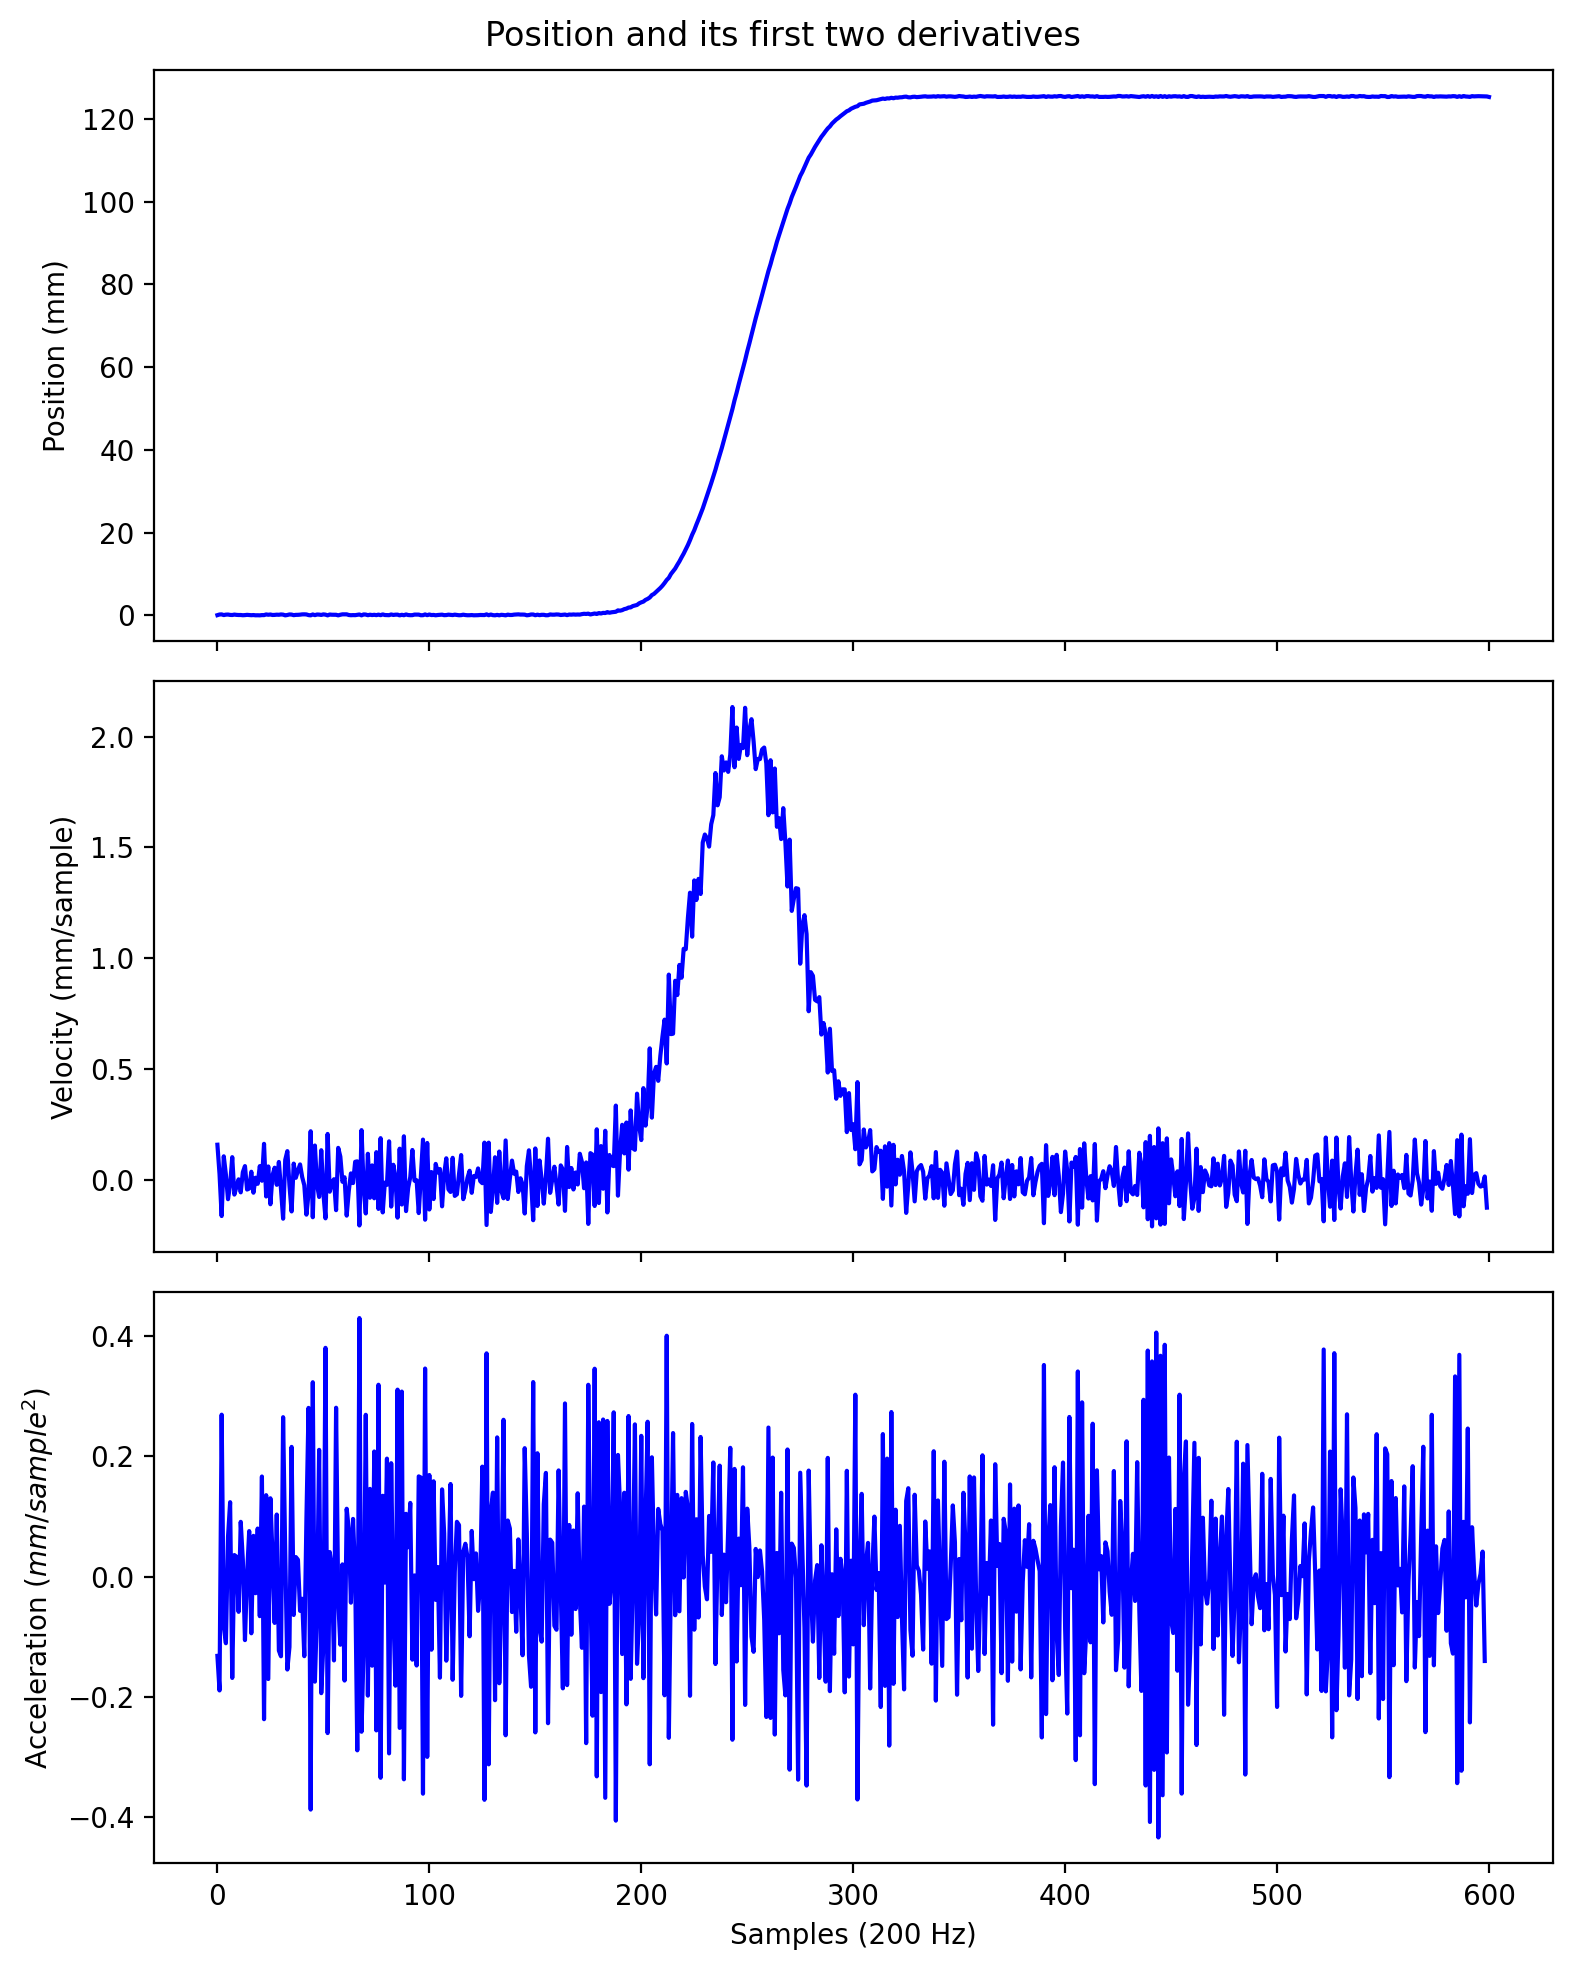

In [12]:
# Plot unfiltered signal and derivatives
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
axs[0].plot(t, pos, c="b")
axs[1].plot(t[0:-1], np.diff(pos), c="b")
axs[2].plot(t[0:-2], np.diff(np.diff(pos)), c="b")

axs[0].set_ylabel("Position (mm)")
axs[1].set_ylabel("Velocity (mm/sample)")
axs[2].set_ylabel("Acceleration ($mm/sample^2$)")
axs[2].set_xlabel("Samples (200 Hz)")

fig.suptitle("Position and its first two derivatives")
plt.tight_layout()

- The top panel shows position in one coordinate over time. 
- The middle panel shows the result of taking the derivative of the position signal to obtain velocity (using the `diff()` function here to obtain a numerical estimate of the derivative). Note how much noisier it looks than the position signal. 
- Finally the bottom panel shows the result of taking the derivative of the velocity signal, to obtain acceleration. It is so noisy one cannot even see the peaks in the acceleration signal, they are completely masked by noise.
- What is happening here is that small amounts of noise in the position signal are amplified each time a derivative is taken. One solution is to **low-pass filter** the position signal. 
- Choice of the cutoff frequency is key — too low and we will decimate the signal itself, and too high and we will not remove enough of the high frequency noise. 
- We happen to be fairly certain in this case that there isn't much real signal power above 12 Hz for arm movements. 
- Here is what it looks like when we low-pass filter the position signal at a 12 Hz cutoff frequency:

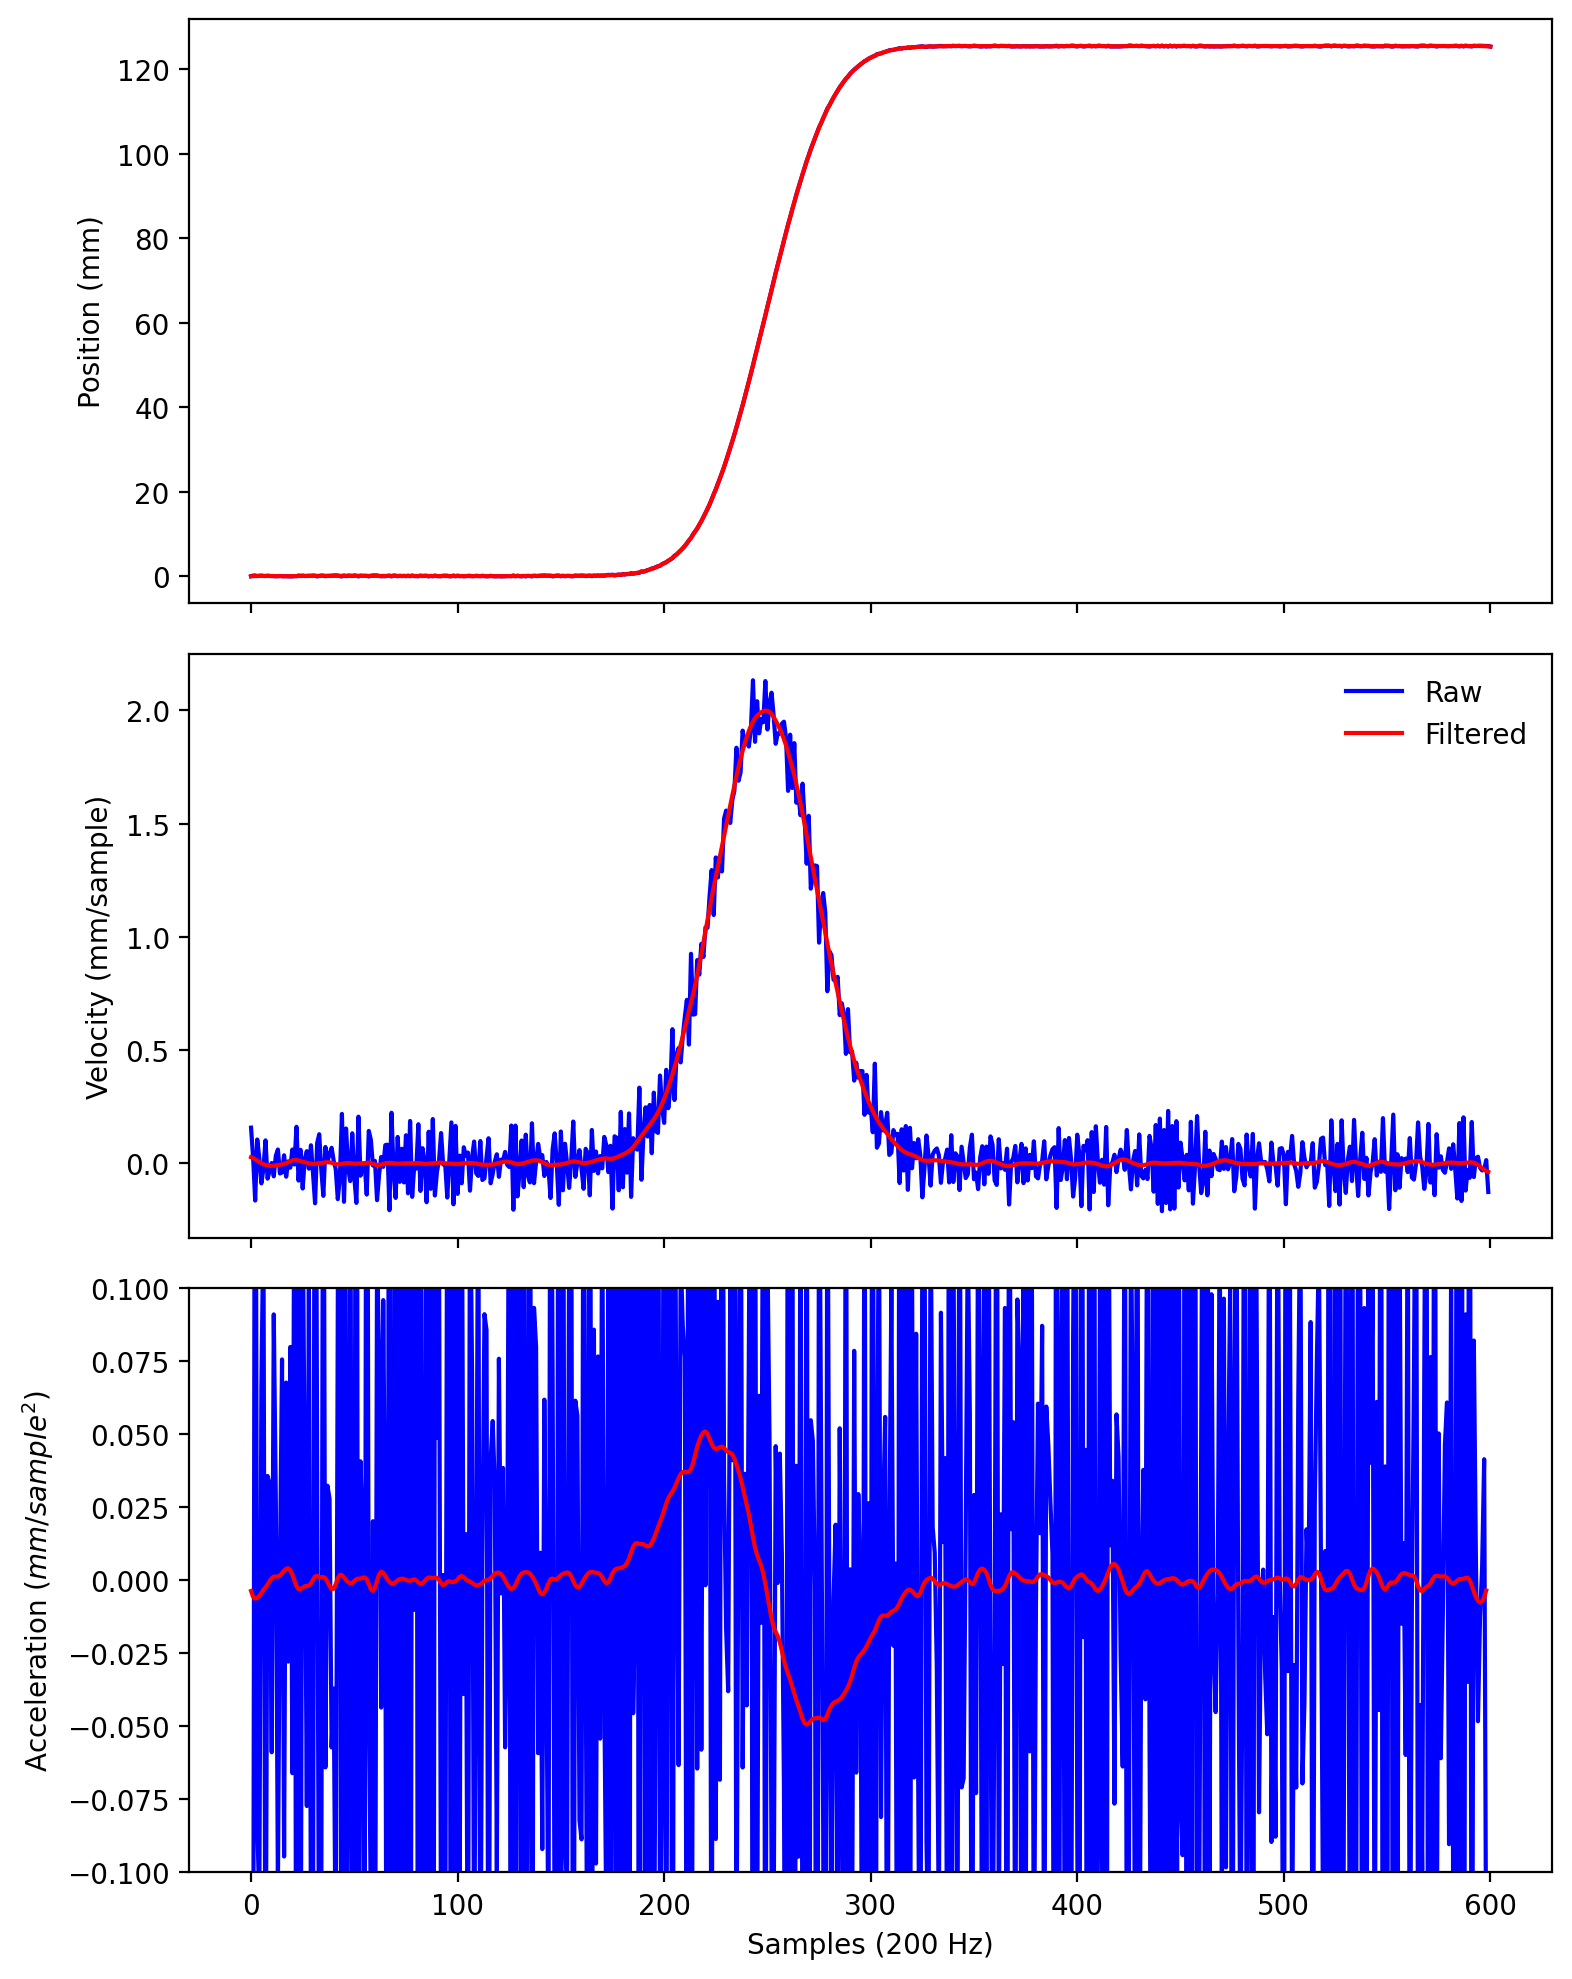

In [13]:
# Low-pass filter position signal
pos_filt = lowpass(pos, samprate=200, cutoff=12)

# Plot unfiltered and filtered signals together
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
axs[0].plot(t, pos, c="b")
axs[0].plot(t, pos_filt, c="r")
axs[0].set_ylabel("Position (mm)")

axs[1].plot(t[0:-1], np.diff(pos), c="b", label="Raw")
axs[1].plot(t[0:-1], np.diff(pos_filt), c="r", label="Filtered")
axs[1].set_ylabel("Velocity (mm/sample)")
axs[1].legend(frameon=False)

axs[2].plot(t[0:-2], np.diff(np.diff(pos)), c="b")
axs[2].plot(t[0:-2], np.diff(np.diff(pos_filt)), c="r")
axs[2].set_ylabel("Acceleration ($mm/sample^2$)")
axs[2].set_ylim([-0.1, 0.1])
axs[2].set_xlabel("Samples (200 Hz)")
plt.tight_layout()

- The filtered version (shown in red) of position doesn't differ that much from the unfiltered version (in blue). 
- The velocity and acceleration traces however look vastly different. 
- Differentiating the filtered position signal yields a velocity trace (shown in red in the middle panel) that is way less noisy than the original version. 
- Taking the derivative again of this new velocity signal yields an acceleration signal (shown in red in the bottom panel) that is actually usable. The original version (shown in blue) is so noisy it overwhelms the entire panel. Note the scale change on the ordinate (y-axis).

## Some common sources of noise

- **Extraneous Signal Noise** arises when a recording device records more than just the signal of interest (e.g., chest electrodes will pick up both cardiac and respiratory muscles). Which is noise depends on what you're interested in.
- **1/f Noise**: low frequency noise power that is inversely proportional to frequency (e.g., EEG systems and EOG systems often show this behaviour) 
- **Power or 60 Hz Noise** is interference from 60 Hz AC electrical power signals. This is one of the most common noise sources that experimental neurophysiologists have to deal with. 
- **Thermal Noise** arises from the thermal motion of electrons in conductors, is always present and determines the theoretical minimum noise levels for a device. Thermal noise is white (has a Gaussian probability distribution) and thus has a flat frequency content — equal power across all frequencies.

## Summary

- In research, we often measure continuous signals by **sampling** them repeatedly over time, at some **sampling frequency**&mdash;i.e., we *discretize* the signals
- All signals can be decomposed into component sines and cosines (i.e., sinusoids)&mdash;this is the idea of Fourier analysis
- Fast Fourier transform (FFT) is a very efficient computational algorithm for computing the magnitude and phase (angle) of these component sines and cosines 
- Filtering leverages the power of FFTs and can be used to remove undesired signal frequencies (typically, noise)
- Python in combination with `SciPy` provide a powerful means for performing FFTs and filtering signals
- Understand these points as well as Shannon-Nyquist theorem and Nyquist frequency, aliasing, time vs frequency domain analyses, practical usage of the FFT and filtering

---
## BONUS MATERIALS FROM TEXTBOOK CHAPTER

## Quantization

Converting an analog signal to a digital form involves the quantization of the analog signal. In this procedure the range of the input variable is divided into a set of class intervals. Quantization involves the replacement of each value of the input variable by the nearest class interval centre.

Another way of saying this is that when sampling an analog signal and converting it to digital values, one is limited by the precision with which one can represent the (analog) signal digitally. Usually a piece of hardware called an analog-to-digital (A/D) board is the thing that performs this conversion. The range of A/D boards are usually specified in terms of **bits**. For example a 12-bit A/D board is capable of specifying $2^{12}=4096$ unique values. This means that a continuous signal will be represented using only 4096 possible values. A 16-bit A/D board would be capable of using $2^{16}=65,536$ different values. Obviously the higher the better, in terms of the resolution of the underlying digital representation. Often however in practice, higher resolutions come at the expense of lower sampling rates.

As an example, let's look at a continuous signal and its digital representation using a variety of (low) sample resolutions:


<center><img src="../images/signal_quantization.jpg" width="800"></center>


Here we see as the number of possible unique values increases, the digital representation of the underlying continuous signal gets more and more accurate. Also notice that in general, quantization adds noise to the representation of the signal.

It is also important to consider the amplitude of the sampled signal compared to the range of the A/D board. In other words, if the signal you are sampling has a very small amplitude compared to the range of the A/D board then essentially your sample will only be occupying a small subset of the total possible values dictated by the resolution of the A/D board, and the effects of quantization will be greatly increased.

For example, let's say you are using an A/D board with 12 bits of resolution and an input range of +/- 5 Volts. This means that you have $2^{12}=4096$ possible values with which to characterize a signal that ranges maximally over 10 Volts. If your signal is very small compared to this range, e.g. if it only occupies 25 millivolts, then the A/D board is only capable of using $0.0025/10*4096 = 10$ (ten) unique values to characterize your signal! The resulting digitized characterization of your signal will not be very smooth.

Whenever possible, amplify your signal to occupy the maximum range of the A/D board you're using. Of course the trick is always to amplify the signal without also amplifying the noise!

---
## Power Spectral Density

Returning the topoic of FFTs, for noisy signals, the FFT taken across the whole signal can be noisy as well, and can make it difficult to see peaks. One solution is instead of performing the FFT on the entire signal all at once, to instead, split the signal into chunks, take the FFT of each chunk, and then average these spectra to come up with a smoother spectrum. This can be accomplished using a [power spectral density](http://www.mathworks.com/help/signal/ref/dspdata.psd.html) function. In SciPy (and in MATLAB) there is a function `psd()` to accomplish this. We won't go into the mathematical details or the theoretical considerations (relating to stochastic processes) but for now suffice it to say that the psd can often give you a better estimate of the power at different frequencies compared to a "plain" FFT.

Here is an example of plotting the power spectral density of a signal in Python / SciPy. We construct a 50 Hz signal at 200 Hz sampling rate, and we add some random noise on top:

/Users/hyosubkim/opt/anaconda3/envs/teaching/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


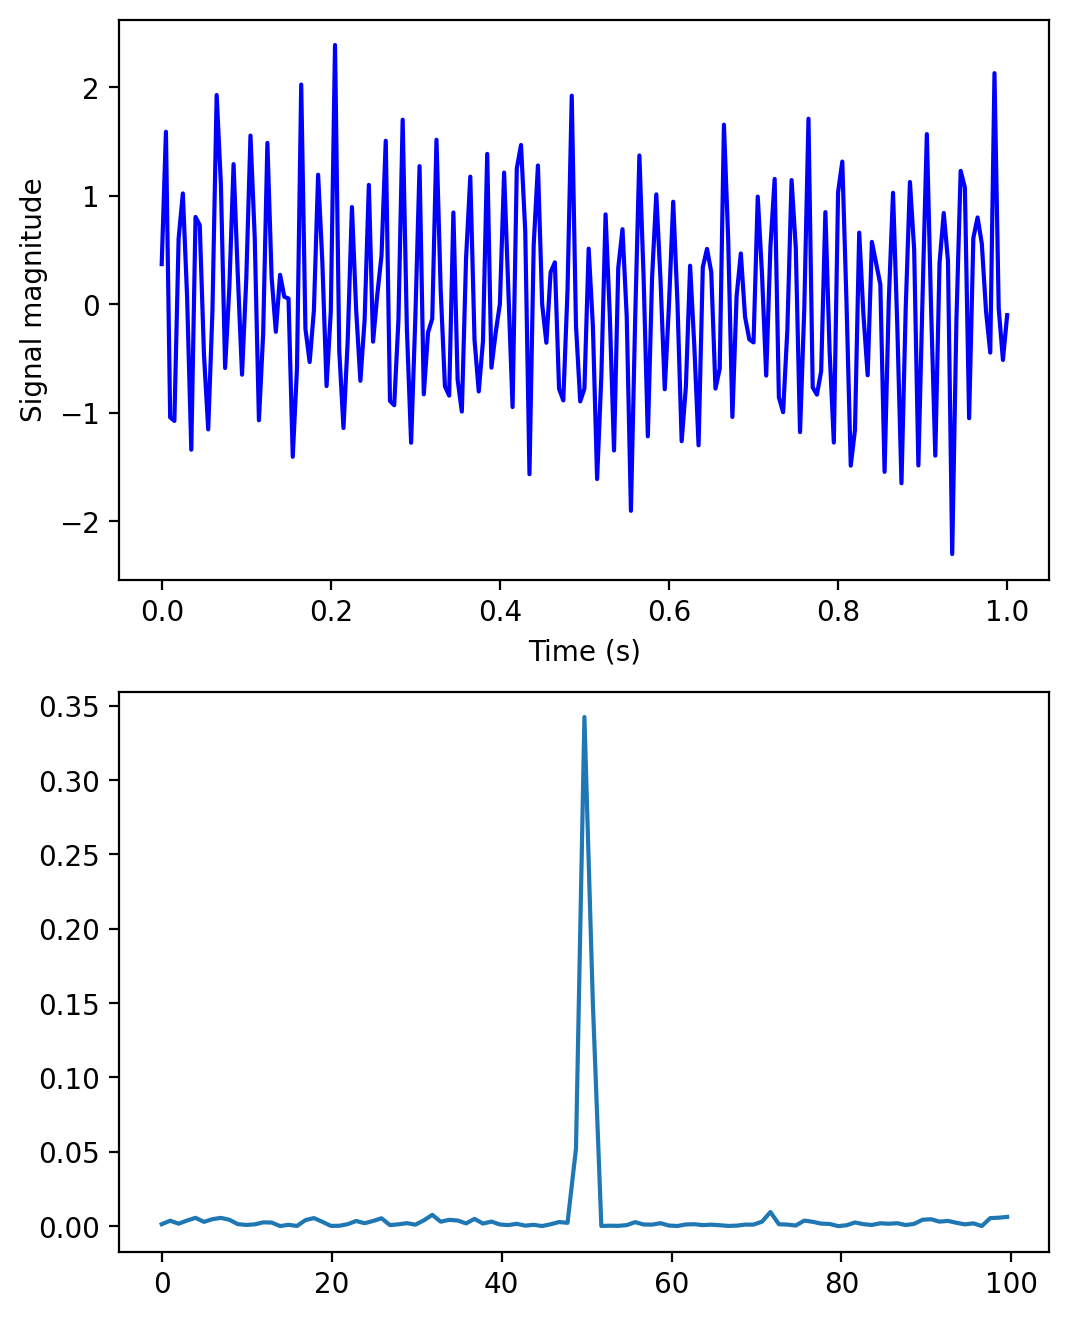

In [14]:
# Construct signal and plot in the time domain
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
t = np.linspace(0, 1, 201)
y = np.sin(2 * np.pi * t * 50) + np.random.randn(len(t)) / 2
ax[0].plot(t, y, c="b")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Signal magnitude")

# Compute and plot the power spectral density
freqs, psd = sp.signal.welch(y, fs=200)
ax[1].plot(freqs, psd)
plt.show()

# # Plot the power spectral density in dB
# ax[1].psd(y, Fs=200, c="b")
# plt.show()

You can see that the peak at 50 Hz stands nicely above all the noise.


## Decibel scale

- Power spectra often displayed in units of decibels (dB) 
- dB scale is a ratio 
- It is commonly used to measure sound level but is also widely used in electronics and signal processing. The dB is a logarithmic unit used to describe a ratio. You will often see power spectra displayed in units of decibels..
- The difference between two sound levels (or two power levels, as in the case of the power spectra above), is defined to be:

$$ 20 \text{log}_{10} \left(\frac{P_{2}}{P_{1}}\right) dB $$

- When $P_{2}$ is twice as large as $P_{1}$, then the difference is about 6 dB. 
- When $P_{2}$ is 10 times as large as $P_{1}$, the difference is 20 dB. 
- A 100 times difference is 40 dB.

## Decibels

- An advantage of using the dB scale is that it is easier to see small signal components in the presence of large ones. In other words large components don't visually swamp small ones.
- Since the dB scale is a ratio scale, to compute absolute levels one needs a reference — a zero point. In acoustics this reference is usually 20 micropascals — about the limit of sensitivity of the human ear.
- For our purposes in the absence of a meaningful reference we can use 1.0 as the reference (i.e. as $P_{1}$ in the above equation).

---
## Spectrogram

Often there are times when you may want to examine how the power spectrum of a signal (in other words its frequency content) changes over time. In speech acoustics for example, at certain frequencies, bands of energy called [formants](http://en.wikipedia.org/wiki/Formant) may be identified, and are associated with certain speech sounds like vowels and vowel transitions. It is thought that the neural systems for human speech recognition are tuned for identification of these formants.

Essentially a spectrogram is a way to visualize a series of power spectra computed from slices of a signal over time. Imagine a series of single power spectra (frequency versus power) repeated over time and stacked next to each other over a time axis.

Matplotlib has a built-in function called `.pyplot.specgram()` that will generate a spectrogram. In the figure below, power is color-coded such that cool colors (blues) represent low power and hot colors (reds) represent high power. 

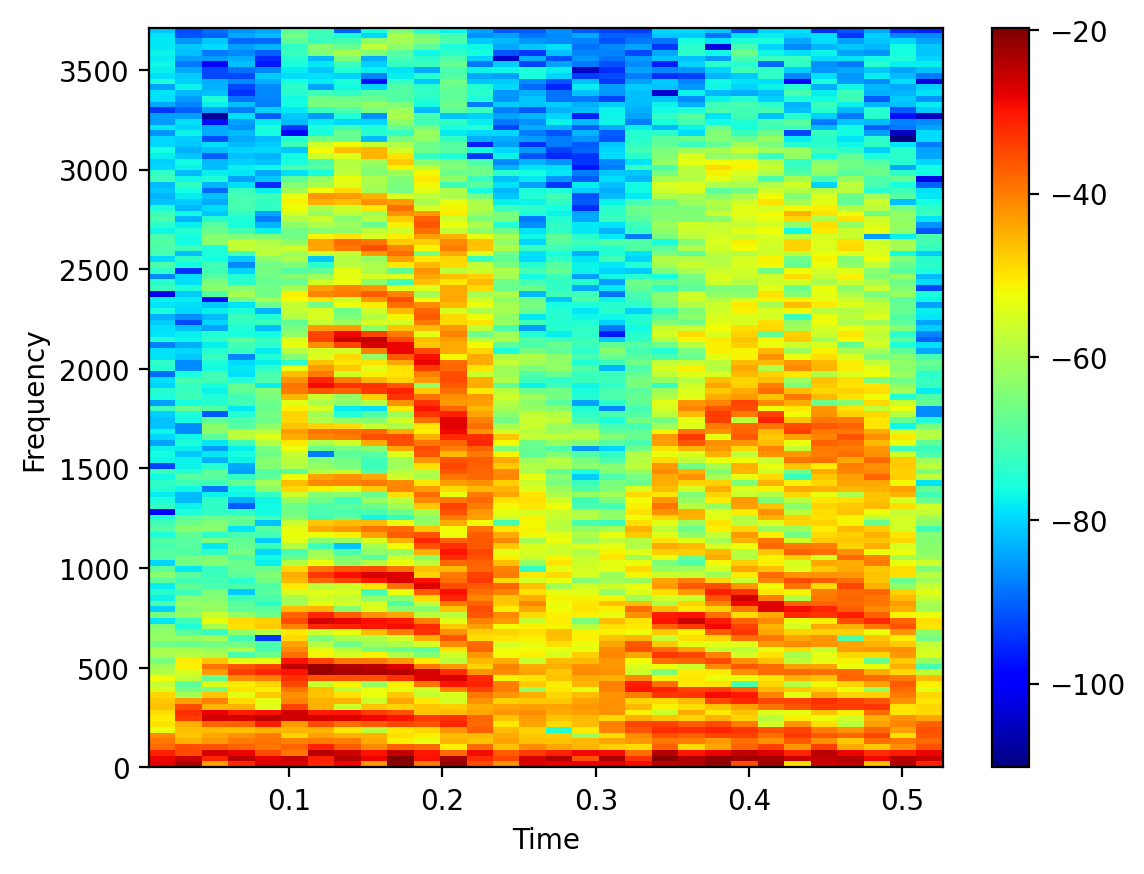

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

mtlb = np.loadtxt('../data/mtlb.txt')
Fs = 7418

fig, ax = plt.subplots()
_, _, _, cax = ax.specgram(mtlb, 256, Fs=Fs, cmap='jet')
ax.set_xlabel("Time")
ax.set_ylabel("Frequency")
fig.colorbar(cax)
plt.show()

## Inverse Fast Fourier transform (IFFT)

Once we have the FFT of a signal, which represents the signal in the frequency domain as a series of magnitude and phase coefficients, we can reconstruct the signal in the time-domain using the inverse fast fourier transform (IFFT). Here is a concrete example:


/Users/hyosubkim/opt/anaconda3/envs/teaching/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/hyosubkim/opt/anaconda3/envs/teaching/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


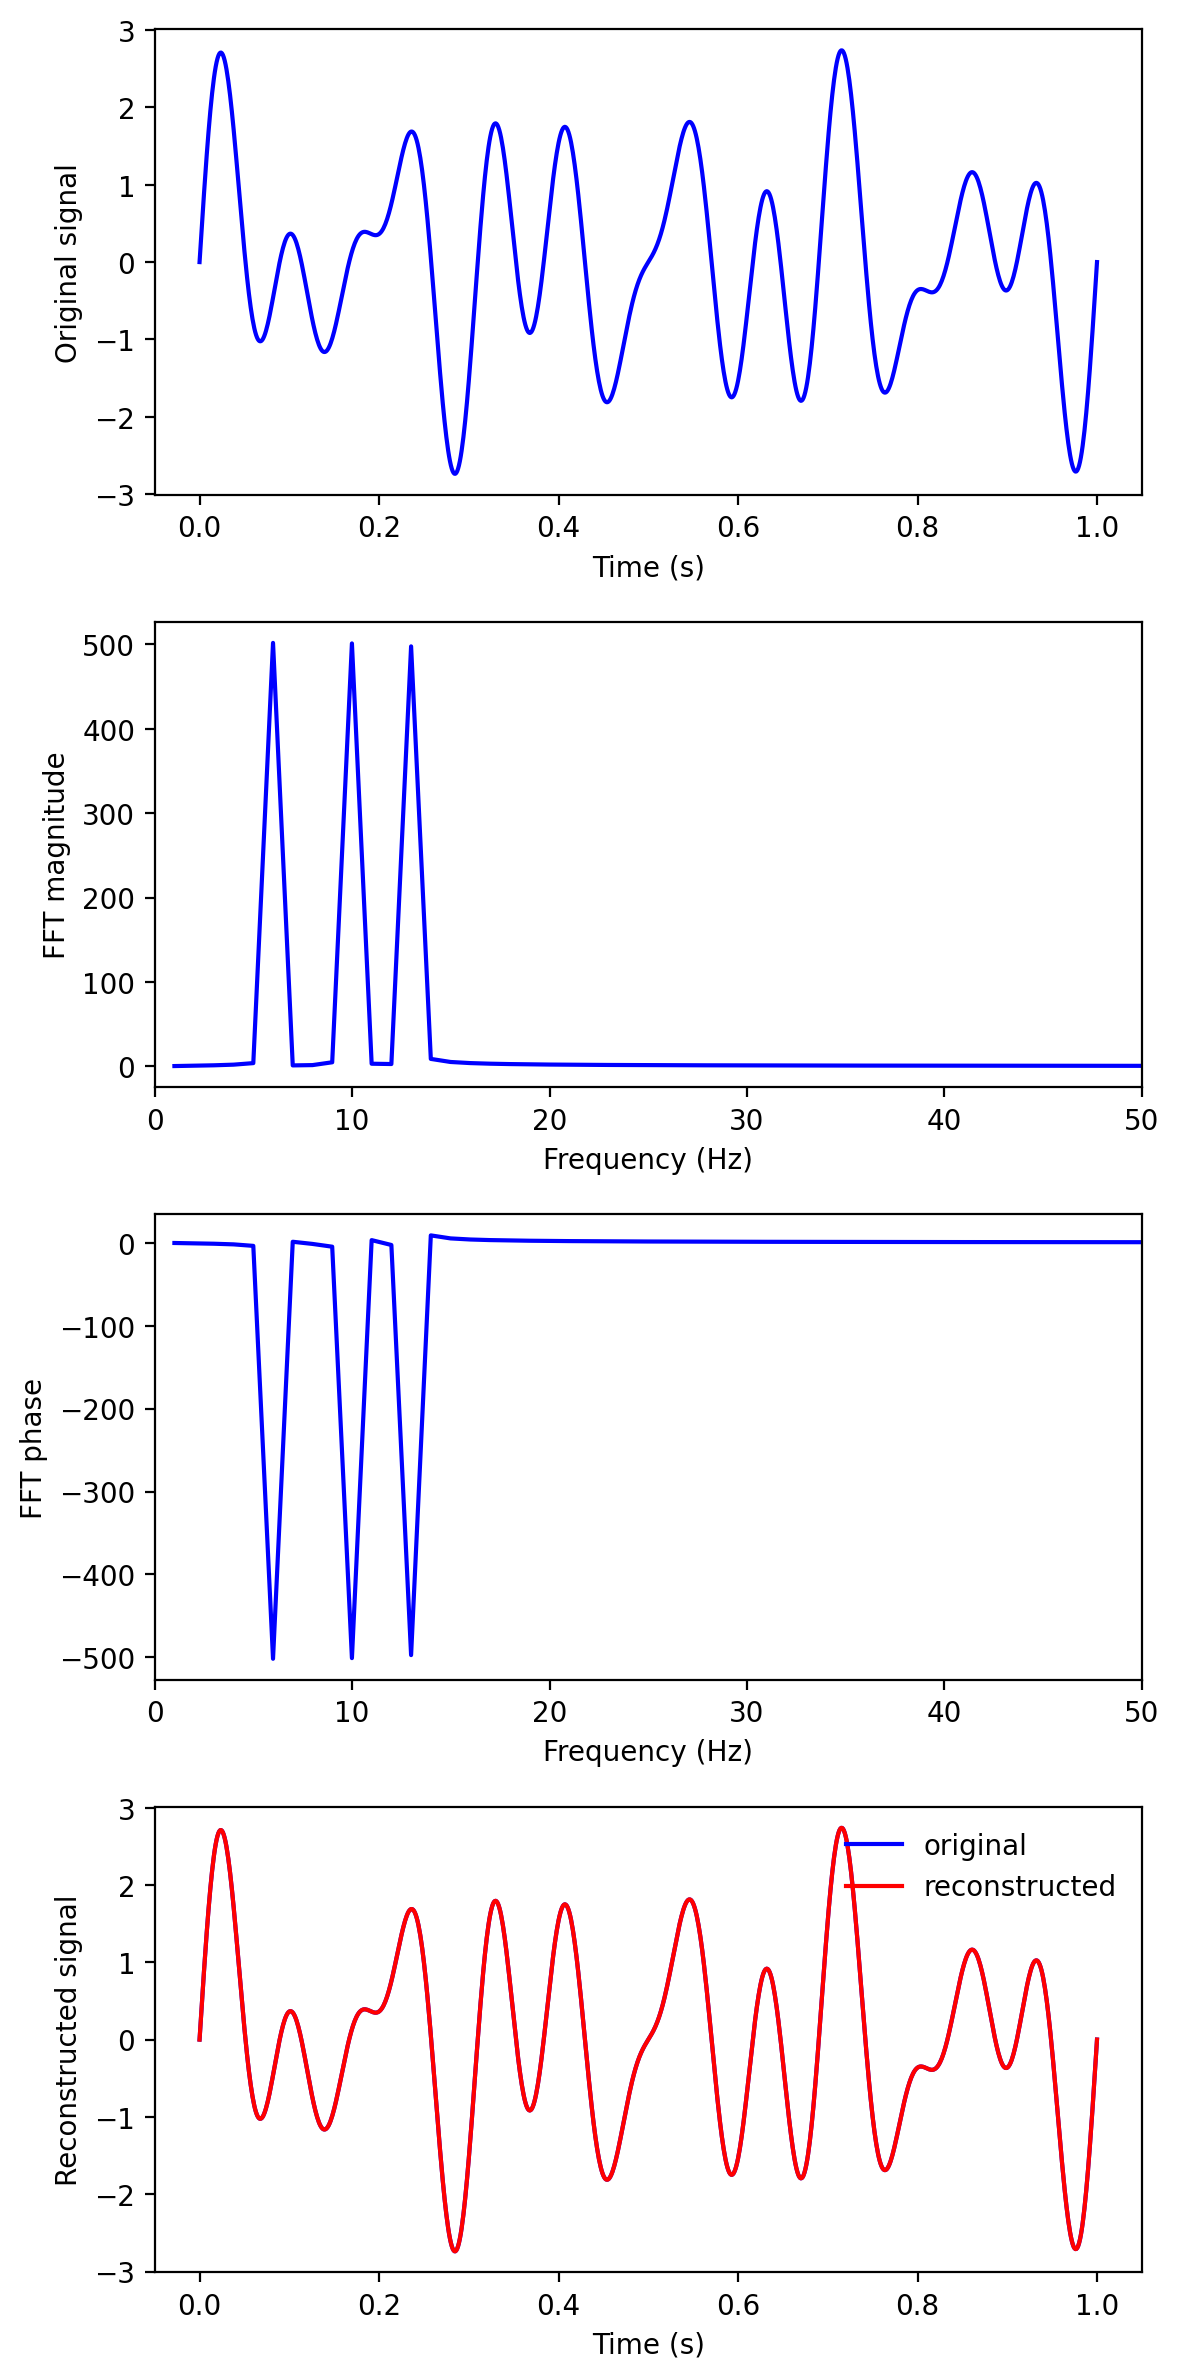

In [16]:
# Construct signal and plot in the time domain
fig, axs = plt.subplots(4, 1, figsize=(6, 12))
t = np.linspace(0, 1, 1001)
y = np.sin(2 * np.pi * t * 6) + np.sin(2 * np.pi * t * 10) + np.sin(2 * np.pi * t * 13)
axs[0].plot(t, y, "b")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Original signal")

# Compute FFT and plot the magnitude spectrum
F = np.fft.fft(y)
N = len(t)  # Number of samples
dt = 0.001  # Inter-sample time difference
w = np.fft.fftfreq(N, dt)  # Gives list of frequencies for FFT
ipos = np.where(w > 0)
freqs = w[ipos]  # Only look at positive fequencies
mags = np.abs(F[ipos])  # Magnitude component
phase = np.imag(F[ipos])  # Phase component
axs[1].plot(freqs, mags, "b")
axs[1].set_xlim([0, 50])  # Zoom in on 0-50 Hz freqs
axs[1].set_ylabel("FFT magnitude")
axs[1].set_xlabel("Frequency (Hz)")

axs[2].plot(freqs, phase, "b")
axs[2].set_xlim([0, 50])  # Zoom in on 0-50 Hz freqs
axs[2].set_ylabel("FFT phase")
axs[2].set_xlabel("Frequency (Hz)")

yr = np.fft.ifft(F)
axs[3].plot(t, y, "b", label="original")
axs[3].plot(t, yr, "r", label="reconstructed")
axs[3].set_xlabel("Time (s)")
axs[3].set_ylabel("Reconstructed signal")
axs[3].legend(frameon=False)
fig.tight_layout()


You can see above that the original signal is reconstructed in its entirety, simply on the basis of its frequency domain representation (the FFT).

### Characterizing filter performance

A useful way of characterizing a filter's performance is in terms of the ratio of the amplitude of the output to the input (the amplitude ratio AR or gain), and the phase shift ($\phi\$) between the input and output, as functions of frequency. A plot of the amplitude ratio and phase shift against frequency is called a [Bode plot](http://en.wikipedia.org/wiki/Bode_plot).

- **Pass band** of a filter is the range of frequencies over which signals pass with no change. 
- **Stop band** refers to the range of frequencies over which a filter attenuates signals. 
- **Cutoff frequency** or **corner frequency** of a filter is used to describe the transition point from the pass band to the reject band. 
- Since this transition cannot occur instantaneously it is usually defined to be the point at which the filter output is equal to -6 dB of the input in the pass band. The **cutoff frequency** is sometimes called the -6 dB point or the half-power point since -6 dB corresponds to half the signal power. 
- **Roll-off** refers to the rate at which the filter attenuates the input after the cutoff point. When the roll-off is linear it can be specified as a specific slope, e.g. in terms of dB/decade (decade is 10x increase in frequency) or dB/octave (octave is a doubling in frequency).

Let's look at some examples of filter characteristics.

<div>
<center><<img src="../images/signal_bode.jpg" width="400"></center></div>
<!-- ![](signal_bode.jpg) -->

In the figure above (spectrum of three filtered versions of a noisy signal with peaks at 6, 10 and 13 Hz) the blue trace shows the power spectrum for the unfiltered signal. The red trace shows a lowpass-filtered version of the signal with a cutoff frequency of 30 Hz. The green trace shows a low-pass with a cutoff frequency of 130 Hz. Also notice that the roll-off of the 30 Hz lowpass is not as great as for the 130 Hz lowpass, which has a higher roll-off.

Here are the corresponding signals shown in the time-domain:

<div>
    <center><img src="../images/signal_bodetime.jpg" width=400></center>
 

So we see a very good example of how low-pass filtering can be used very effectively to filter out random noise. Key is the appropriate choice of cut-off frequency.

### Common Filters

There are many different designs of filters, each with their own characteristics (gain, phase and delay characteristics). Some common types:

*   **Butterworth Filters** have frequency responses which are maximally flat and have a monotonic (no change in direction) roll-off. They are well behaved and this makes them very popular choices for simple filtering applications. Probably most common filter used in motor control and learning research.
*   **Tschebyschev Filters** provide a steeper monotonic roll-off, but at the expense of some ripple (oscillatory noise) in the pass-band.
*   **Cauer Filters** provide a sharper roll-off still, but at the expense of ripple in both the pass-band and the stop-band, and reduced stop-band attenuation.
*   **Bessel Filters** have a phase-shift which is linear with frequency in the pass-band. This corresponds to a pure delay and so Bessel filters preserve the shape of the signal quite well. The roll-off is monotonic and approaches the same slope as the Butterworth and Tschebyschev filters at high frequencies although it has a more gentle roll-off near the corner frequency.

### Filter order

In [filter design](http://en.wikipedia.org/wiki/Filter_design) the **order** of a filter is one characteristic that you might come across. Technically the definition of the filter order is the highest exponent in the [z-domain](http://en.wikipedia.org/wiki/Z-transform) ([transfer function](http://en.wikipedia.org/wiki/Transfer_function)) of a [digital filter](http://en.wikipedia.org/wiki/Digital_filter). That's helpful isn't it?! Another way of describing filter order is the degree of the approximating polynomial for the filter. Yet another way of describing it is that increasing the filter order increases roll-off and brings the filter closer to the ideal response (i.e. a "brick wall" roll-off).

Practically speaking, you will find that a second-order butterworth filter provides a nice sharp roll-off without too much undesirable side-effects (e.g. large time lag, ripple in the pass-band, etc).

See [this section](http://en.wikipedia.org/wiki/Low-pass_filter#Continuous-time_low-pass_filters) of the wikipedia page on low-pass filters for another description.

---
## End-of-Chapter Exercise

Here is some Python code to generate a complex signal composed of sinusoids at several frequencies. The signal is sampled at 1000 Hz.


In [17]:
t = np.arange(0, 0.5, 1 / 1000)  # 500 ms of time at 1000 Hz
y1 = np.sin(2 * np.pi * 30 * t)  # pure sinusoid at  30 Hz
y2 = np.sin(2 * np.pi * 60 * t) + np.random.normal(len(t))  # 60 Hz noise  
y3 = np.sin(2 * np.pi * 125 * t)  # pure sinusoid at 125 Hz
y4 = np.sin(2 * np.pi * 300 * t)  # pure sinusoid at 300 Hz
y = y1 + (0.7 * y2) + (0.8 * y3) + (0.9 * y4)

### Complete the following steps. 

You may find it covenient to plot everything using subplots. The point of this exercise is to understand at a conceptual level some of the objectives of this chapter, as well as the mechanics of using Python to filter signals. You don't have to worry about all of the ins-and-outs of filtering, but you should understand the outputs of the code and be able to explain what's happening at each stage.  

**Step 1.** Plot the signal y in the time domain. Label the axes and include a title.

**Step 2.** Plot the magnitude spectrum of y using the scipy.signal.welch() function. Label the axes and include a title.

**Step 3.** Highpass filter the signal to remove the 30 Hz component. Plot the filtered signal in the time domain and also plot the magnitude (power) spectrum of the filtered signal. Label the axes and include a title.

**Step 4.** Lowpass the filtered signal from Step 3 to remove the 300 Hz component. Plot the filtered signal in the time domain and also plot the magnitude spectrum of the filtered signal. Label the axes and include a title.

**Step 5.** Knock out the 60 Hz noise. Verify the electrical (60 Hz) noise was removed. 

In [18]:
# Your answer here

# Part 1 - Plot your signal in time domain


# Part 2 - Plot magnitude spectrum (power spectral density) 


# Part 3 - Apply high-pass filter to signal and plot


# Part 4 - Apply low-pass filter to signal and plot


# Part 5 - Apply bandstop filter to signal and plot


### Think!

What do you notice about the relationship between cut-off frequencies and magnitude spectra, and are you surprised? What's the explanation? What frequency band did you have to use to knock out the 60 Hz noise completely? 

---
## Acknowledgment

This chapter was copied and lightly adapted (mostly code edits) from Paul Gribble's <a href="https://gribblelab.org/teaching/scicomp2020/">Scientific Computing</a> course under a <a href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. Some of the topics here are more advanced. The goal is to provide you an introduction to this extremely important topic as well as some conceptual and practical understanding. Hence, you may find a lot of value in returning to this chapter in the future, whether to boost your understanding or utilize the code examples provided. 
